## CNN → LSTM Pipeline (Final Model)

For the next stage of our ablation study, we built a model that uses **raw frame-level features extracted by a CNN**, rather than hand-crafted AU features. The motivation was to test whether automatically learned visual features could improve emotion classification performance when paired with a temporal model.

### Pipeline Overview

Here's how this model works:

- First, we sample **30 evenly spaced frames** from each video.
- Each frame is passed through a **pre-trained CNN (MobileNetV2)** to extract high-level spatial features. We remove the classification head and only use the convolutional layers followed by global average pooling to get a 1D feature vector per frame.
- These 30 frame-level vectors are stacked together to form a feature sequence for the video.
- The sequence is passed through an **LSTM**, which learns the temporal dynamics across frames.
- Finally, a fully connected layer outputs a binary prediction — "anger" or "neutral".

### Why This Model Was an Improvement

Compared to the LSTM model using OpenFace AU annotations, this CNN → LSTM model performed slightly better overall. It showed improvements in both precision and recall, especially when it came to correctly identifying anger cases. This aligns with our hypothesis that learned spatial features might capture subtleties that hand-crafted AUs miss — like context-specific facial patterns, background clues, or slight head movements.

### Ablation Insight

This comparison between the OpenFace AU-based LSTM and our CNN → LSTM model acts as a clear ablation study:

- **OpenFace LSTM** focused solely on temporal dynamics of predefined facial muscle movements.
- **CNN → LSTM** allowed the network to learn its own visual features directly from the frame pixels, potentially capturing richer and more flexible representations.

By comparing both approaches under the same conditions (same video samples, same LSTM structure, same training setup), we were able to isolate the impact of the feature extraction method itself — showing that the CNN-based approach provided a more powerful foundation for anger classification in gameplay videos.

Epoch 1/25
41/41 [==============================] - 3s 33ms/step - loss: 0.7371 - accuracy: 0.4540 - val_loss: 0.6773 - val_accuracy: 0.6098 - lr: 3.0000e-04
Epoch 2/25
41/41 [==============================] - 1s 26ms/step - loss: 0.6791 - accuracy: 0.5521 - val_loss: 0.6807 - val_accuracy: 0.5610 - lr: 3.0000e-04
Epoch 3/25
41/41 [==============================] - 1s 26ms/step - loss: 0.6363 - accuracy: 0.6380 - val_loss: 0.6493 - val_accuracy: 0.6341 - lr: 3.0000e-04
Epoch 4/25
41/41 [==============================] - 1s 25ms/step - loss: 0.6384 - accuracy: 0.6442 - val_loss: 0.6601 - val_accuracy: 0.6585 - lr: 3.0000e-04
Epoch 5/25
41/41 [==============================] - 1s 26ms/step - loss: 0.6043 - accuracy: 0.7117 - val_loss: 0.6341 - val_accuracy: 0.6098 - lr: 3.0000e-04
Epoch 6/25
41/41 [==============================] - 1s 26ms/step - loss: 0.5573 - accuracy: 0.7669 - val_loss: 0.6317 - val_accuracy: 0.6829 - lr: 3.0000e-04
Epoch 7/25
41/41 [==============================] - 

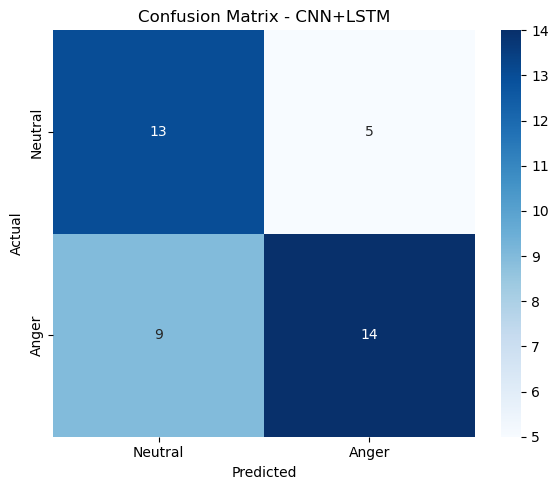

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Path to my video dataset
video_base_path = r"C:\Users\henry\Downloads\Final_project\CMPT419_Dataset"
video_folders = [("Anger", 1), ("Neutral", 0)]  # labeling anger as 1 and neutral as 0
frame_count = 30  # I’m using 30 frames per video
frame_size = (224, 224)  # MobileNetV2 needs this size

# Load MobileNetV2 to extract features from each frame
cnn_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
cnn_model = Sequential([
    cnn_base,
    GlobalAveragePooling2D()  # this flattens the output to 1D per frame
])

# Function to extract frames from a video
def extract_frames(video_path, count=30):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_idxs = np.linspace(0, total_frames - 1, count).astype(int)  # even spread
    frames = []
    for idx in frame_idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, frame_size)
        frame = frame.astype("float32") / 255.0  # normalize
        frames.append(frame)
    cap.release()
    return np.array(frames)

# Loop through all videos and extract features
X, y = [], []
for folder_name, label in video_folders:
    folder_path = os.path.join(video_base_path, folder_name)
    for file in os.listdir(folder_path):
        if file.endswith(".mp4"):
            video_path = os.path.join(folder_path, file)
            frames = extract_frames(video_path, frame_count)
            if frames.shape[0] != frame_count:
                continue  # skip if frames are missing
            features = cnn_model.predict(frames, verbose=0)
            X.append(features)
            y.append(label)

X = np.array(X)
y = np.array(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Handle class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(enumerate(class_weights))

# Build the actual LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.5))  # dropout to avoid overfitting
model.add(Dense(64, activation='relu'))  # hidden dense layer
model.add(Dense(1, activation='sigmoid'))  # output layer (binary)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Add callbacks to stop early or reduce learning rate
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=4,
    verbose=1,
    callbacks=[early_stop, lr_scheduler],
    class_weight=class_weights_dict
)

# Save the model for web app
model.save("cnn_lstm_anger_classifier.h5")

# Predict on test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int")  # threshold at 0.5

# Show results
print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Neutral", "Anger"]))

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Neutral", "Anger"], yticklabels=["Neutral", "Anger"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CNN+LSTM")
plt.tight_layout()
plt.show()